<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=146221191" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    #ema_125 = df.ta.ema(125, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [3]:
!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  33.1714285714286

Range:  fear

Datetime:  2023-10-12 00:00:00+00:00

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [4]:
from datetime import datetime
today = pd.Timestamp(datetime.now()).strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2023-10-12.

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: HCM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 17.510000228881836

Ichimoku 9-Day Forecast: 16.547500371932983

Ichimoku 26-Day Forecast: 15.640000343322754

Choppiness (%): 50.83

RSI: 63.671488427364835

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

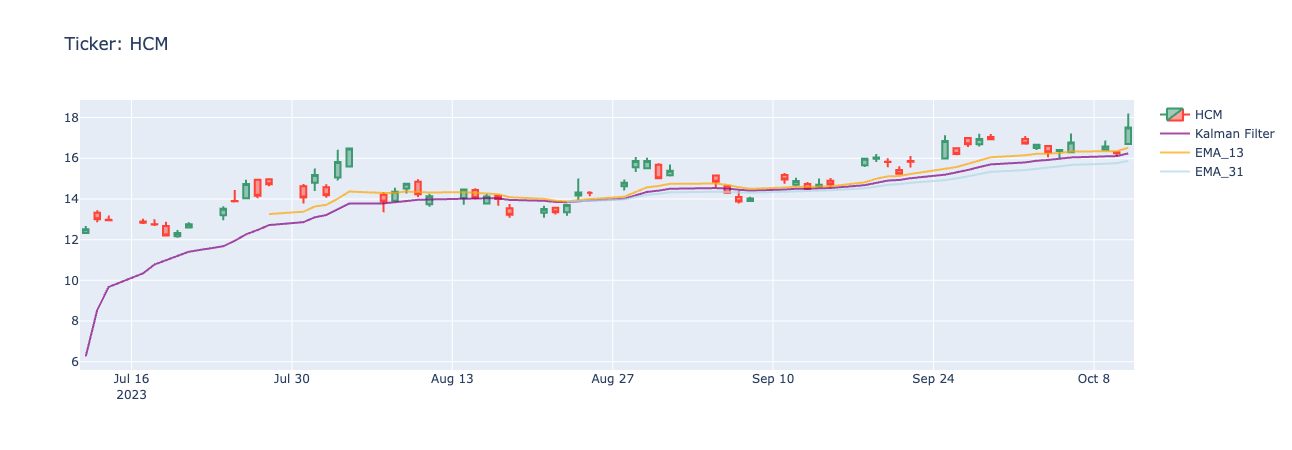

Ticker: HMY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 4.539999961853027

Ichimoku 9-Day Forecast: 4.057500004768372

Ichimoku 26-Day Forecast: 4.020000100135803

Choppiness (%): 36.04

RSI: 64.91835867443756

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

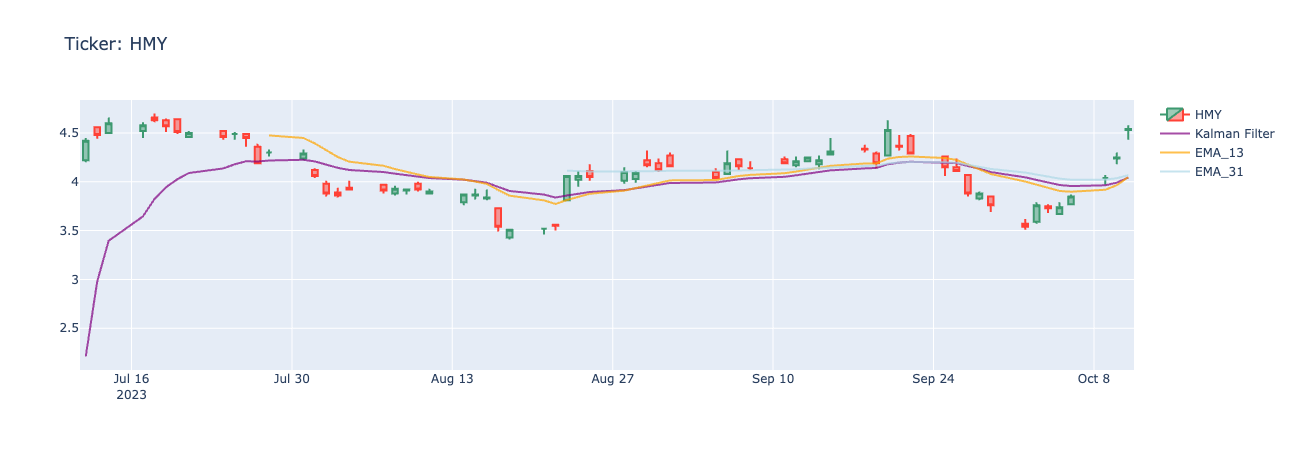

Ticker: NTNX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 38.91999816894531

Ichimoku 9-Day Forecast: 36.25999927520752

Ichimoku 26-Day Forecast: 33.734999656677246

Choppiness (%): 50.29

RSI: 73.54867187590108

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

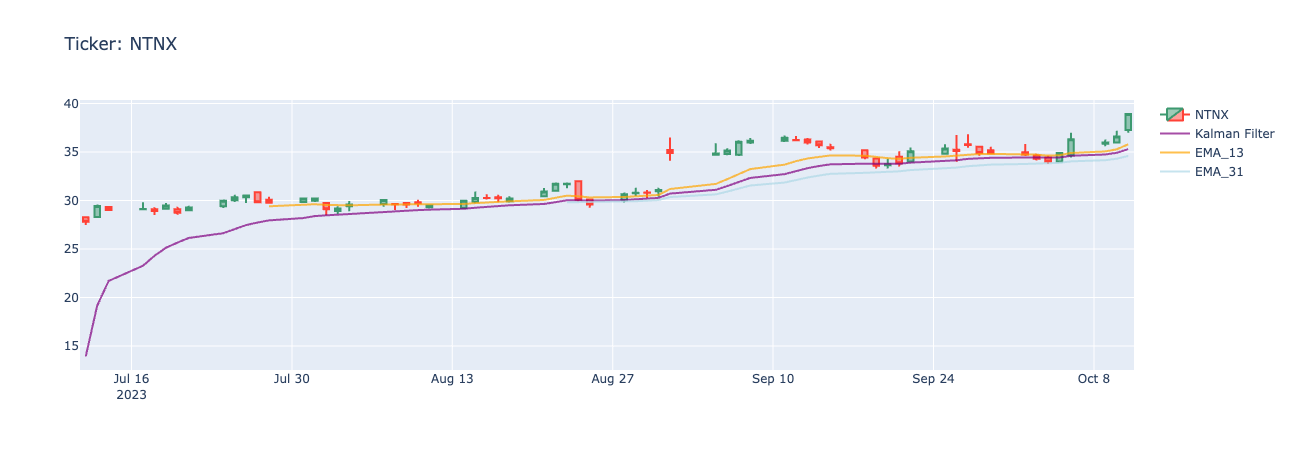

Ticker: NVO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 98.83999633789062

Ichimoku 9-Day Forecast: 93.5049991607666

Ichimoku 26-Day Forecast: 89.5374984741211

Choppiness (%): 40.24

RSI: 66.59877045582147

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

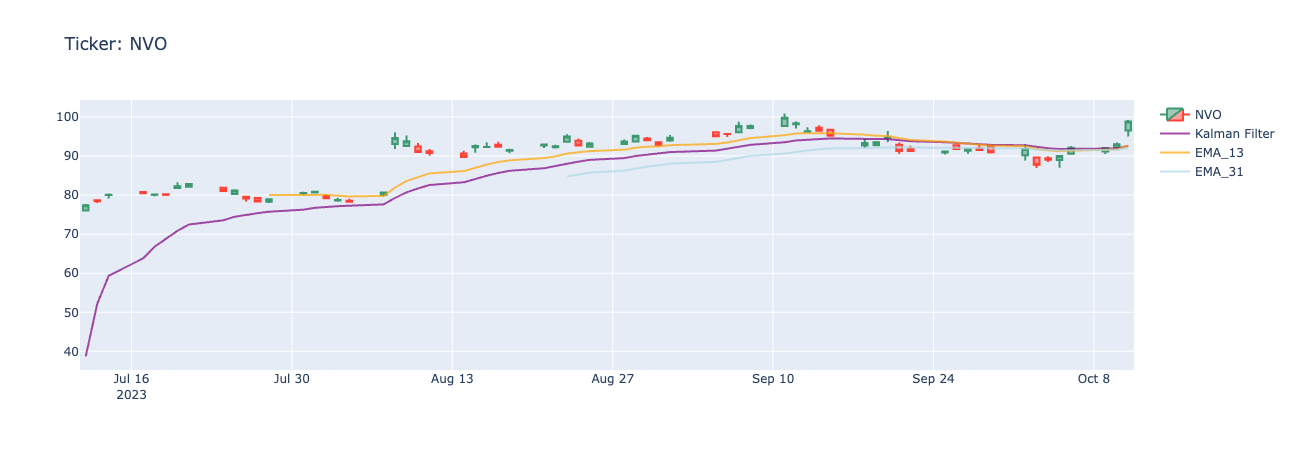

Ticker: LSRCY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 34.400001525878906

Ichimoku 9-Day Forecast: 31.88749933242798

Ichimoku 26-Day Forecast: 31.28999900817871

Choppiness (%): 44.44

RSI: 70.61914830969843

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

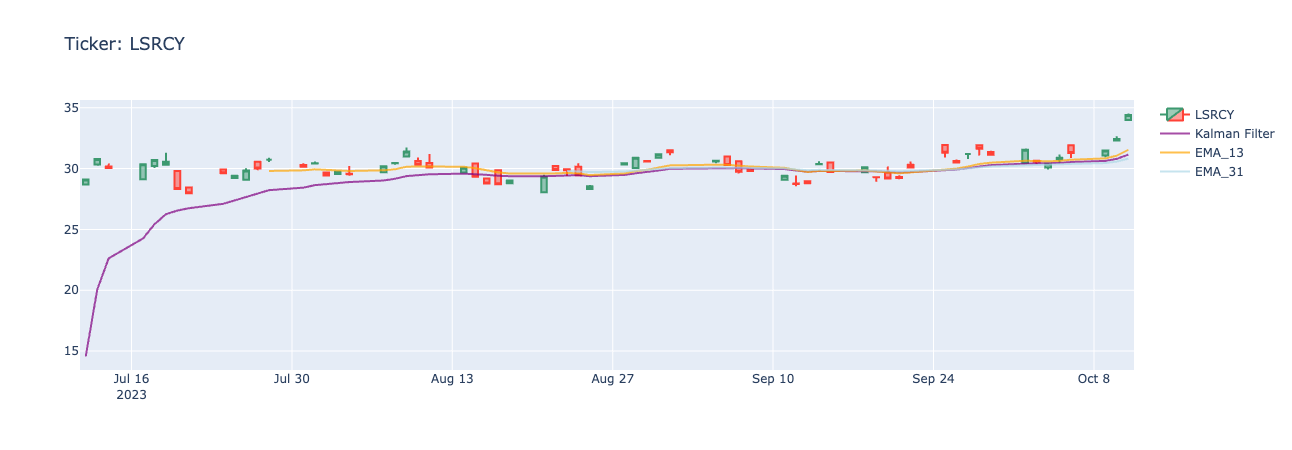

Ticker: BHVN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 27.700000762939453

Ichimoku 9-Day Forecast: 23.49250078201294

Ichimoku 26-Day Forecast: 22.075000762939453

Choppiness (%): 35.24

RSI: 72.21597503903799

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

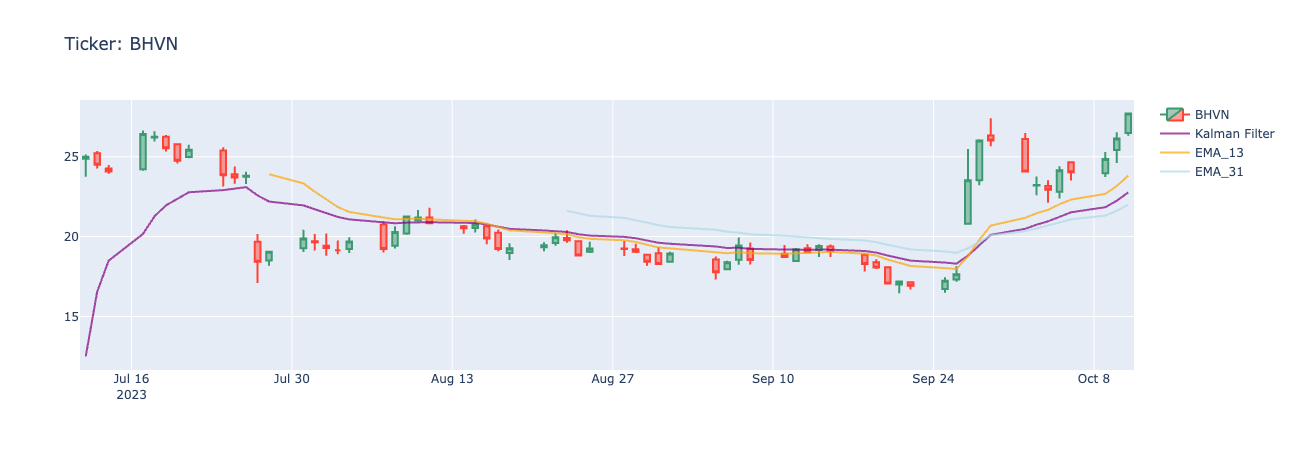

Ticker: SYM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 41.84000015258789

Ichimoku 9-Day Forecast: 36.53249931335449

Ichimoku 26-Day Forecast: 46.88000011444092

Choppiness (%): 31.64

RSI: 66.91842169491814

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

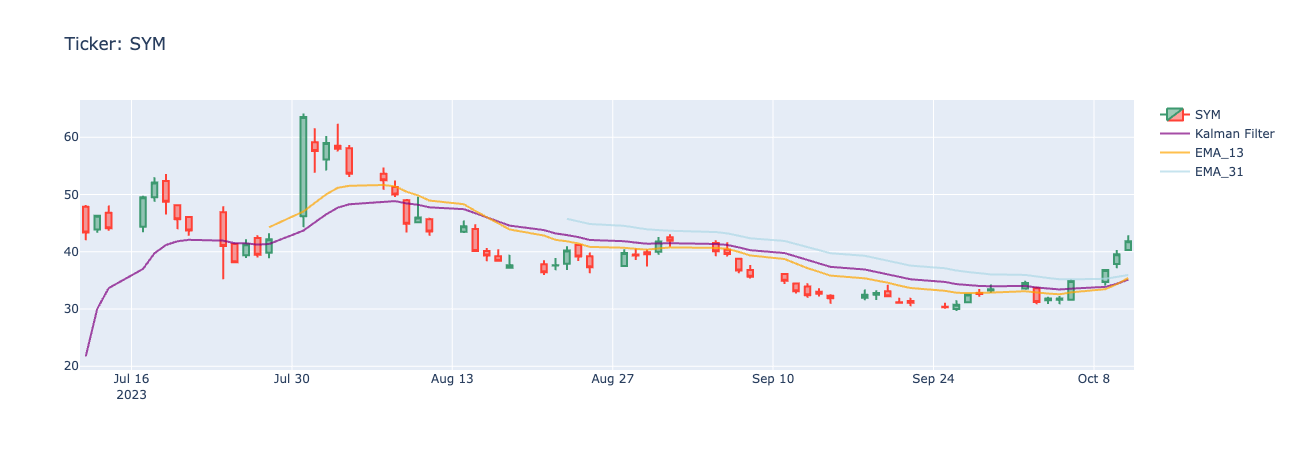

Ticker: GPS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 11.529999732971191

Ichimoku 9-Day Forecast: 10.642499923706055

Ichimoku 26-Day Forecast: 10.565000057220459

Choppiness (%): 48.89

RSI: 62.84839123337541

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

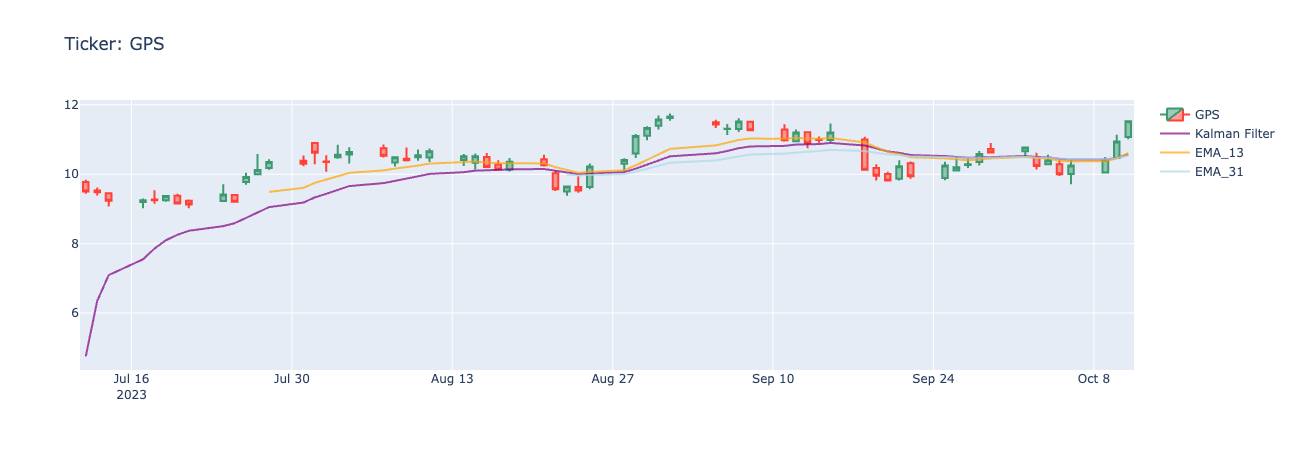

Ticker: AMGN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 283.6000061035156

Ichimoku 9-Day Forecast: 269.17749786376953

Ichimoku 26-Day Forecast: 256.2699966430664

Choppiness (%): 42.47

RSI: 72.08472078190826

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

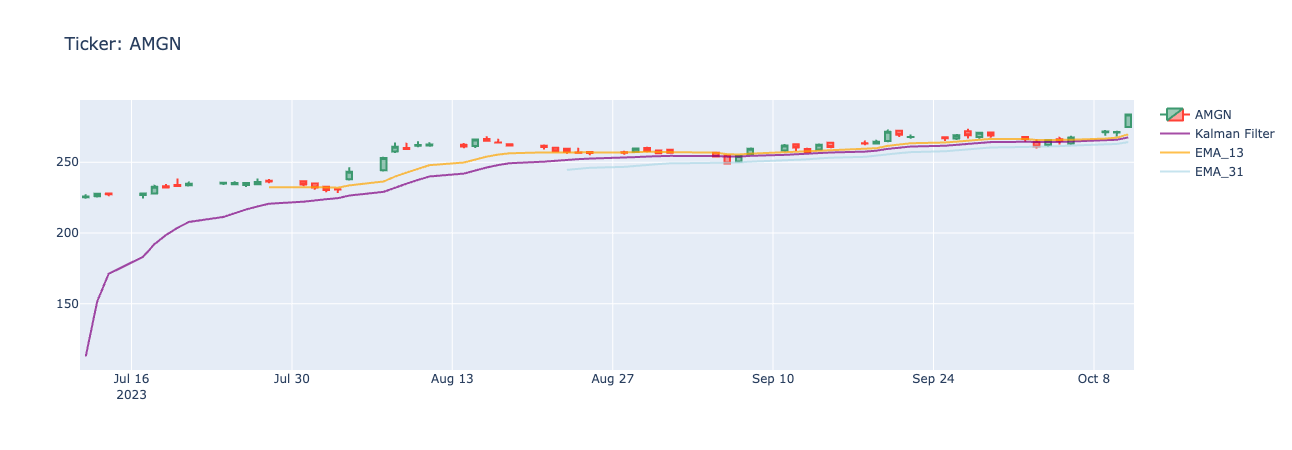

Ticker: LLY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 605.280029296875

Ichimoku 9-Day Forecast: 562.6799926757812

Ichimoku 26-Day Forecast: 527.8399963378906

Choppiness (%): 29.15

RSI: 71.47992835004793

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

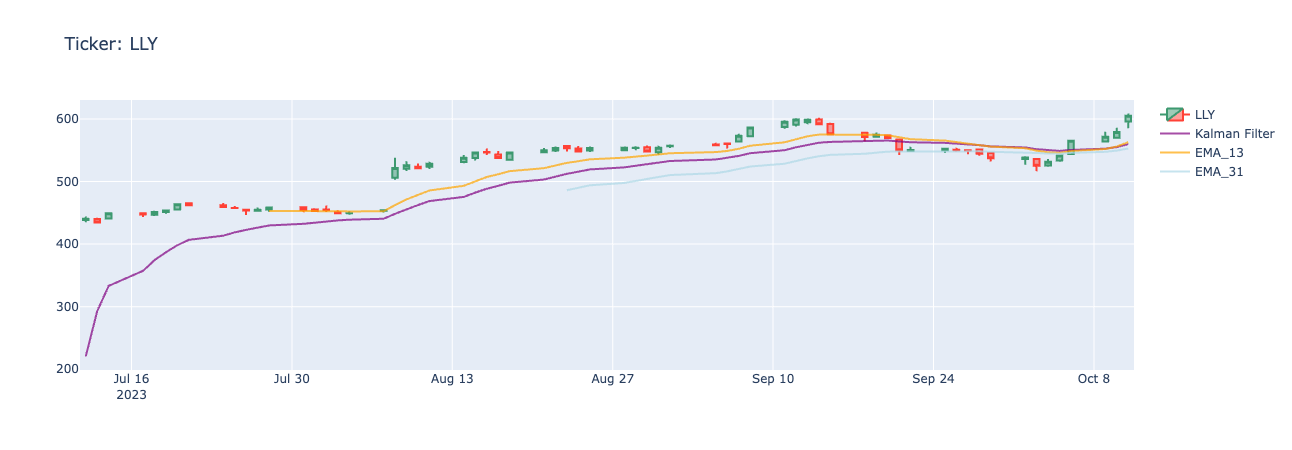

Ticker: STX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 69.55999755859375

Ichimoku 9-Day Forecast: 67.1875

Ichimoku 26-Day Forecast: 68.47000122070312

Choppiness (%): 47.86

RSI: 63.95977655678656

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

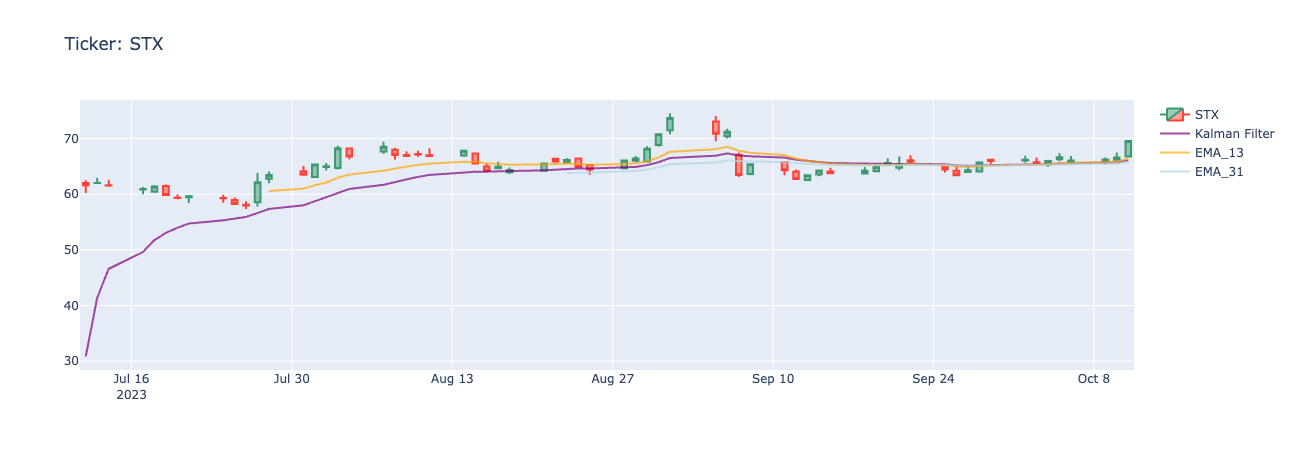

Ticker: IVSBF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 20.0

Ichimoku 9-Day Forecast: 19.460000038146973

Ichimoku 26-Day Forecast: 19.4399995803833

Choppiness (%): 12.75

RSI: 67.3172773832293

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

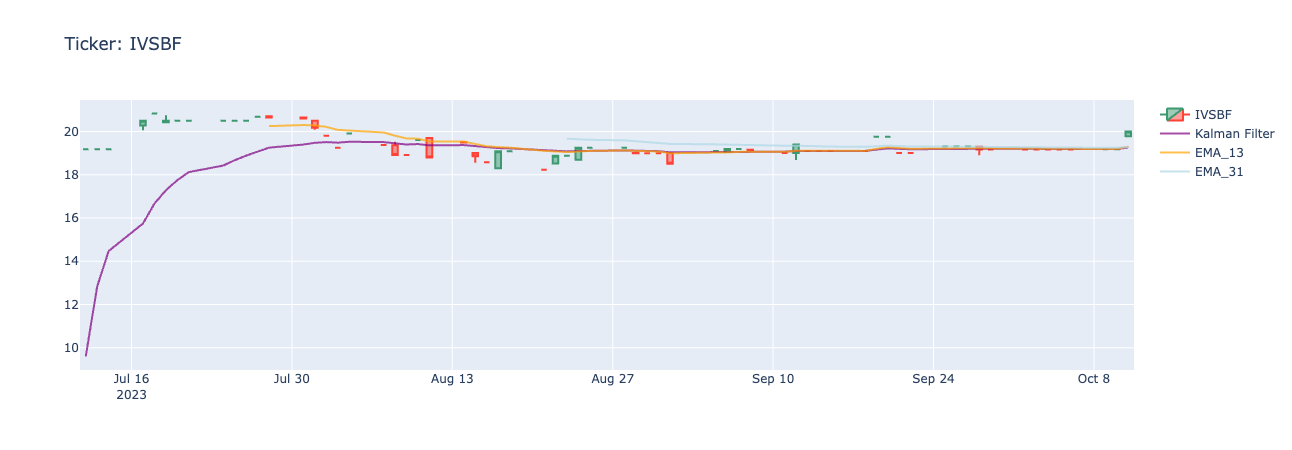

Ticker: ESLT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 214.64999389648438

Ichimoku 9-Day Forecast: 206.06249618530273

Ichimoku 26-Day Forecast: 205.52499389648438

Choppiness (%): 42.20

RSI: 66.94450337360345

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

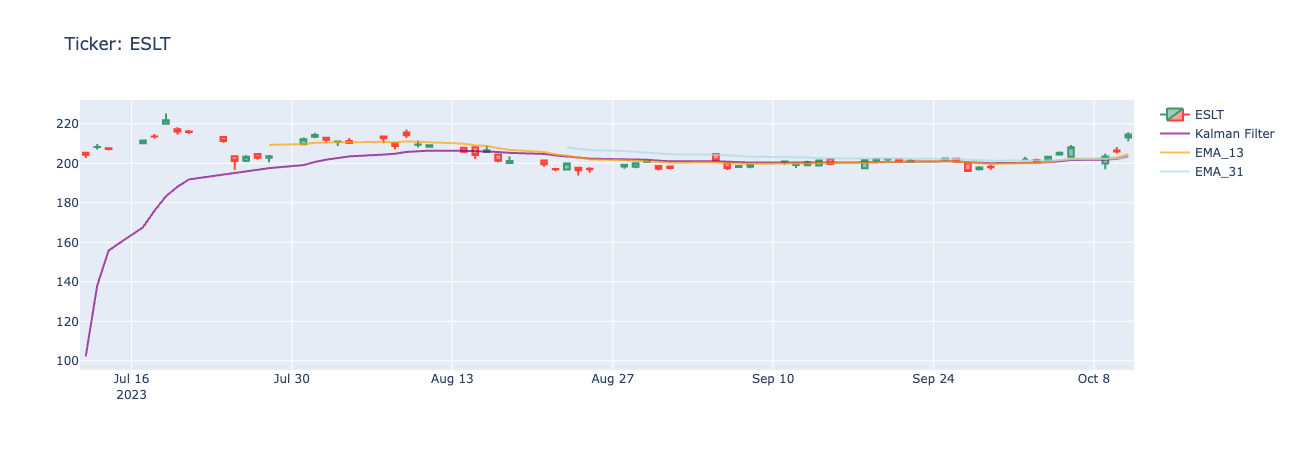

Ticker: GNW

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 6.019999980926514

Ichimoku 9-Day Forecast: 5.805000066757202

Ichimoku 26-Day Forecast: 5.884999990463257

Choppiness (%): 70.46

RSI: 56.46857363898583

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

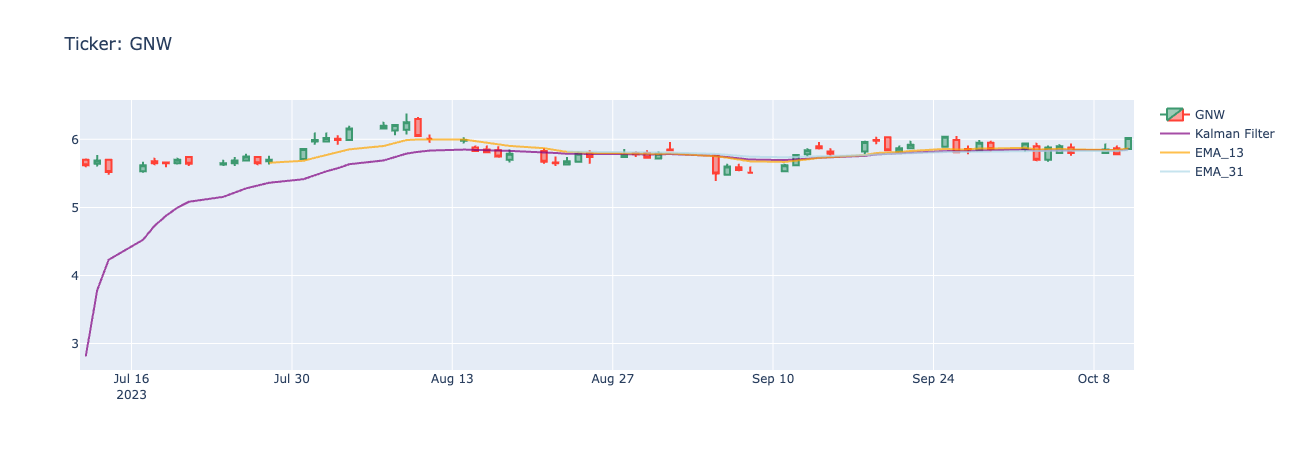

Ticker: FYBR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 16.6299991607666

Ichimoku 9-Day Forecast: 15.15749979019165

Ichimoku 26-Day Forecast: 16.41249990463257

Choppiness (%): 49.70

RSI: 60.21849548794472

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

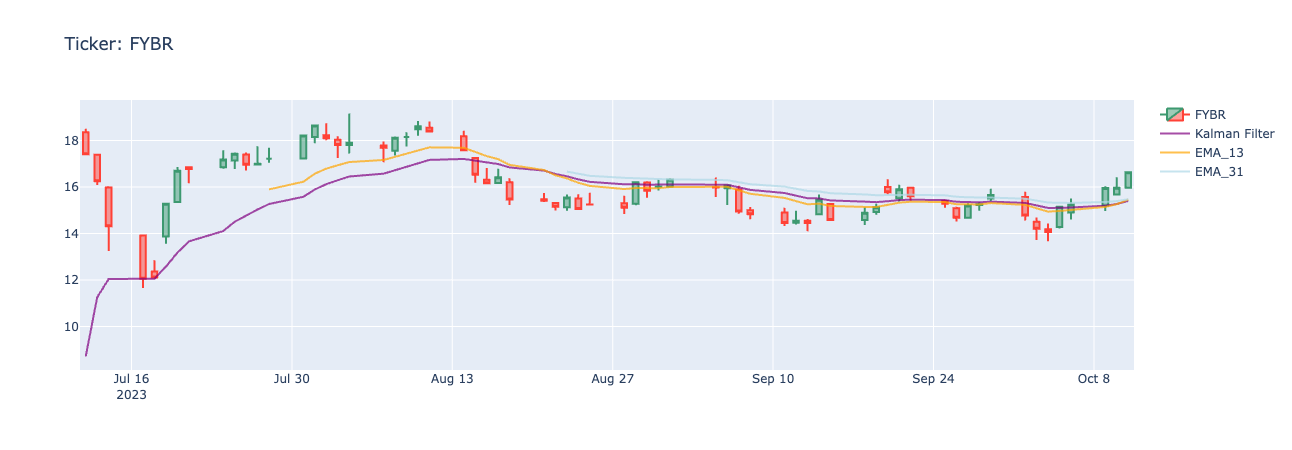

Ticker: MOD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 51.09000015258789

Ichimoku 9-Day Forecast: 47.63499927520752

Ichimoku 26-Day Forecast: 43.84499931335449

Choppiness (%): 45.01

RSI: 70.01924255612278

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

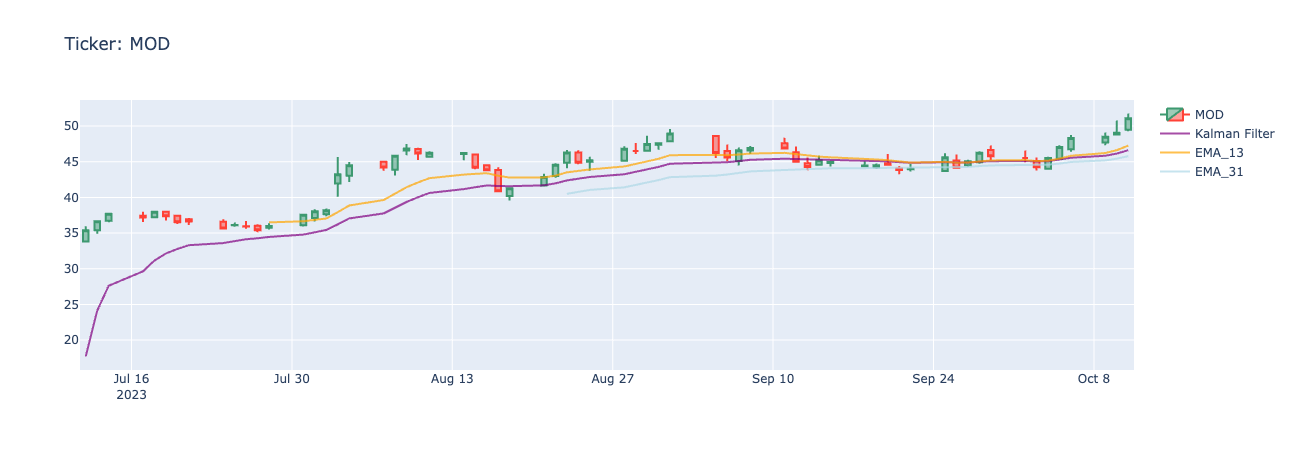

Ticker: WXXWY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 12.15999984741211

Ichimoku 9-Day Forecast: 11.382500171661377

Ichimoku 26-Day Forecast: 11.005000114440918

Choppiness (%): 45.98

RSI: 65.21442234901323

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

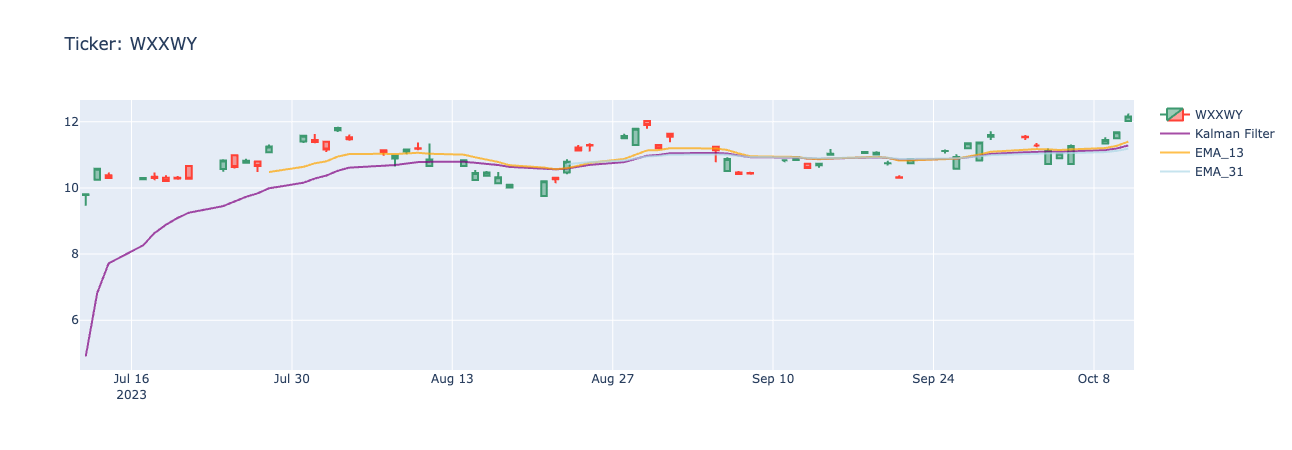

Ticker: NRG

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 41.27000045776367

Ichimoku 9-Day Forecast: 38.94499969482422

Ichimoku 26-Day Forecast: 38.6299991607666

Choppiness (%): 44.57

RSI: 67.81820394755749

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

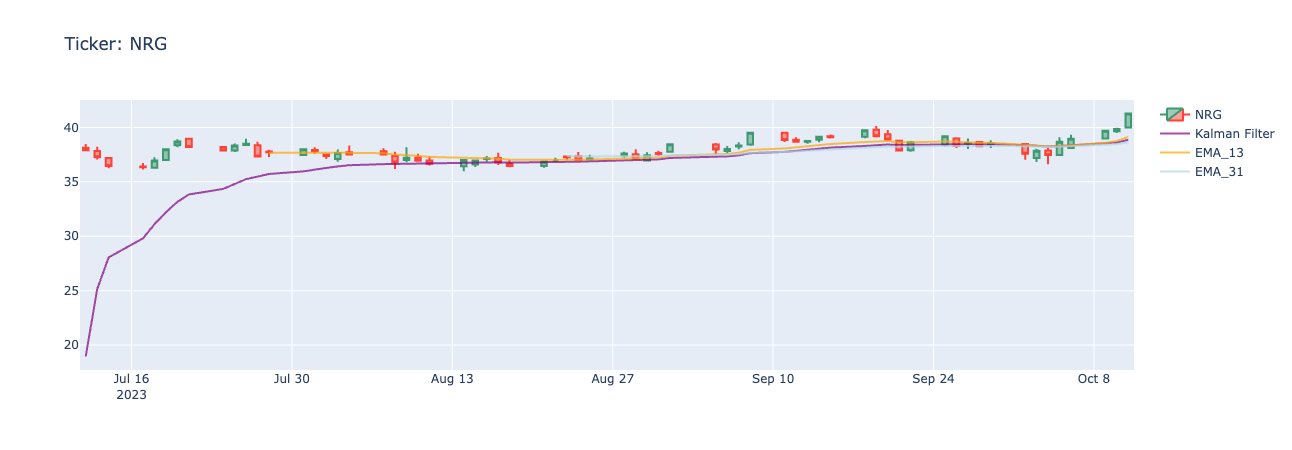

Ticker: RNR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 213.1999969482422

Ichimoku 9-Day Forecast: 202.41749954223633

Ichimoku 26-Day Forecast: 193.76499938964844

Choppiness (%): 44.24

RSI: 68.59874384496123

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

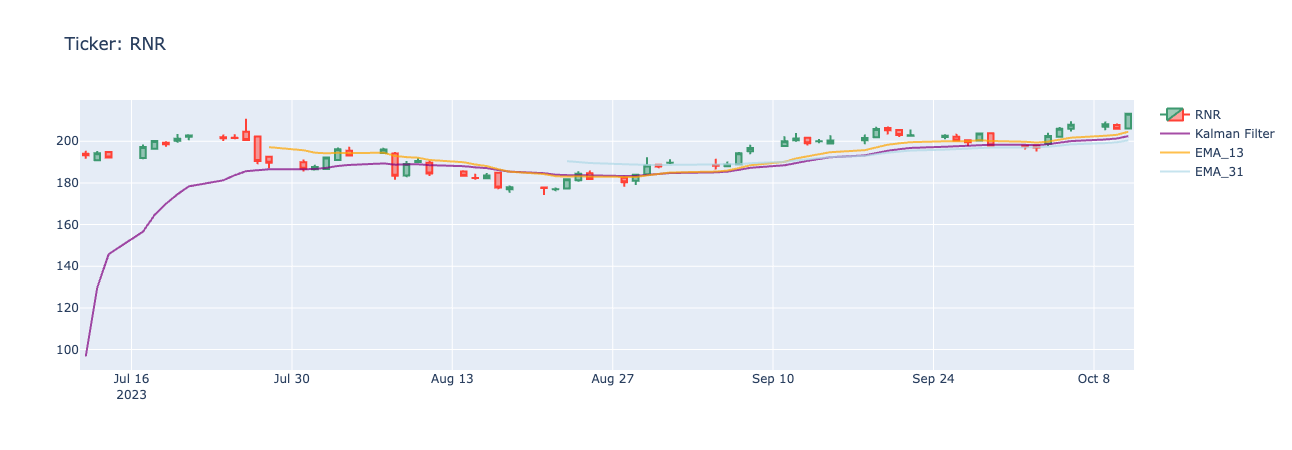

Ticker: DELL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 70.33999633789062

Ichimoku 9-Day Forecast: 67.95249938964844

Ichimoku 26-Day Forecast: 62.43499946594238

Choppiness (%): 49.80

RSI: 63.79220979738068

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

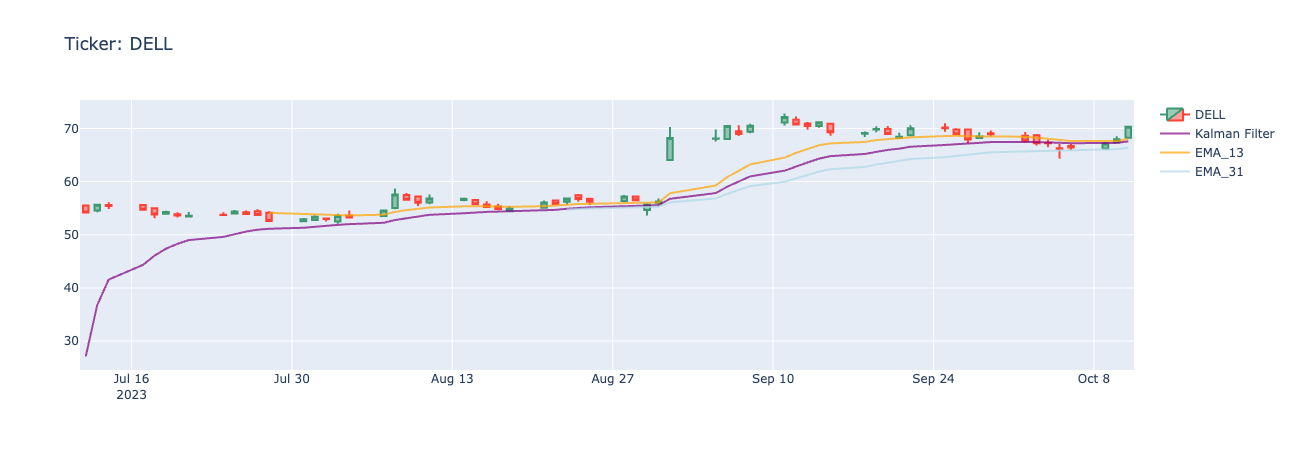

Ticker: OKTA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 87.97000122070312

Ichimoku 9-Day Forecast: 82.41750144958496

Ichimoku 26-Day Forecast: 79.76000213623047

Choppiness (%): 43.98

RSI: 66.4011083780668

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

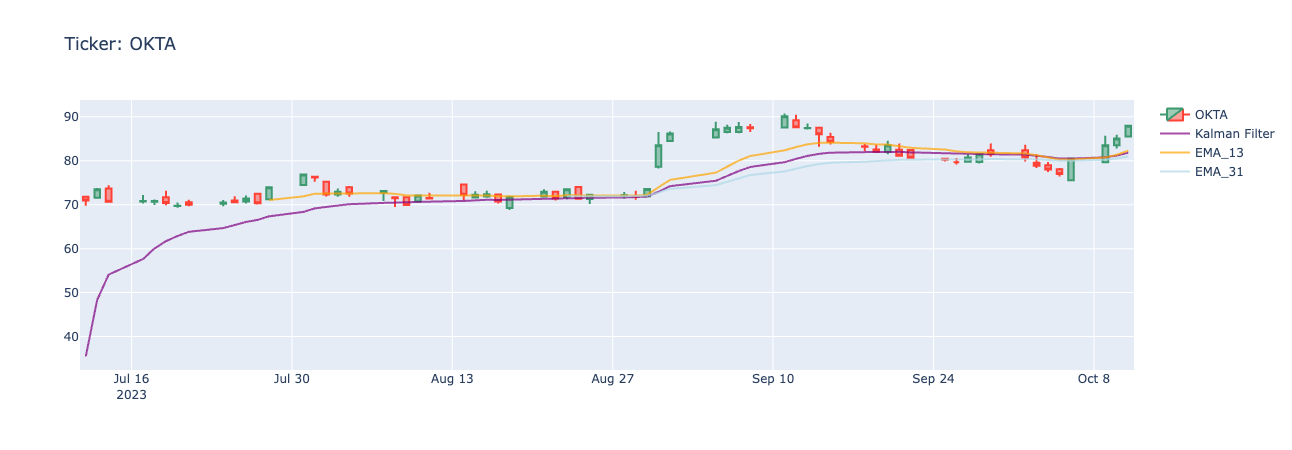

Ticker: RPD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 50.38999938964844

Ichimoku 9-Day Forecast: 47.40999984741211

Ichimoku 26-Day Forecast: 45.810001373291016

Choppiness (%): 43.10

RSI: 65.56892751653967

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

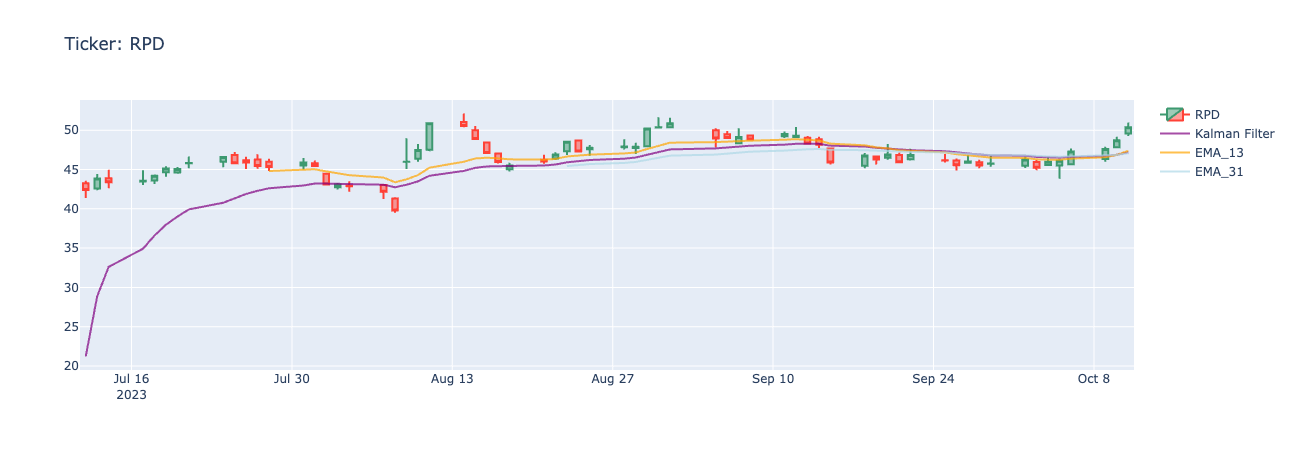

Ticker: STLA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 20.25

Ichimoku 9-Day Forecast: 19.332499980926514

Ichimoku 26-Day Forecast: 19.139999389648438

Choppiness (%): 48.34

RSI: 65.62517020396206

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

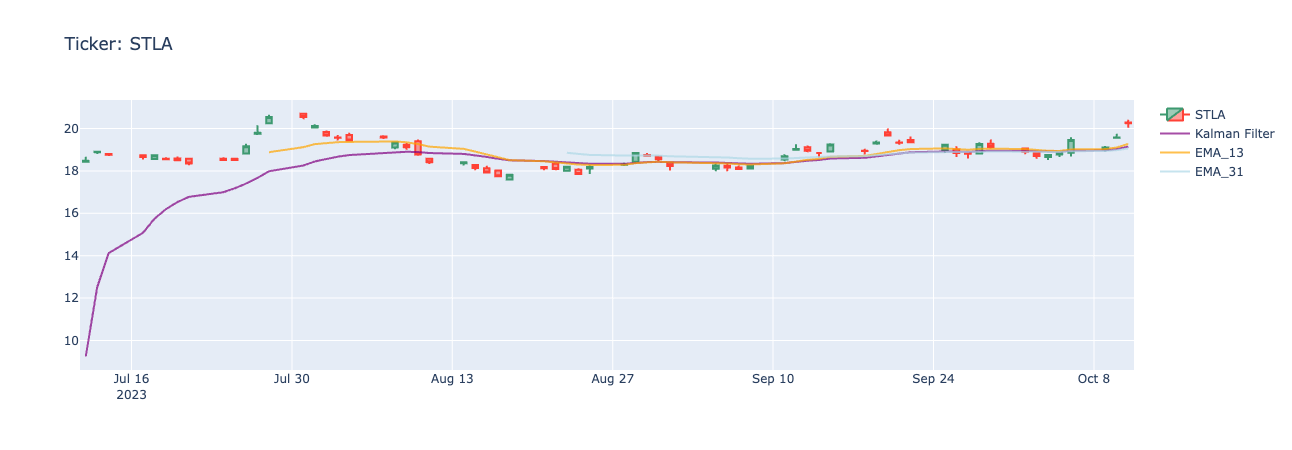

Ticker: SPT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 52.54999923706055

Ichimoku 9-Day Forecast: 49.68499946594238

Ichimoku 26-Day Forecast: 50.83749961853027

Choppiness (%): 59.11

RSI: 59.9762278349855

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

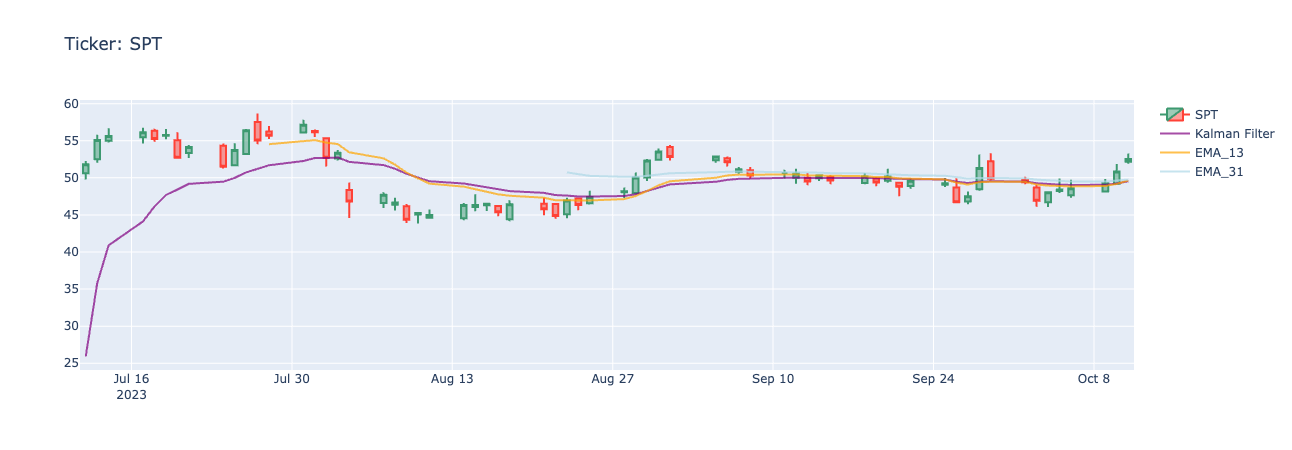

Ticker: NFE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 33.560001373291016

Ichimoku 9-Day Forecast: 30.592500686645508

Ichimoku 26-Day Forecast: 30.1225004196167

Choppiness (%): 45.10

RSI: 61.355672643967665

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

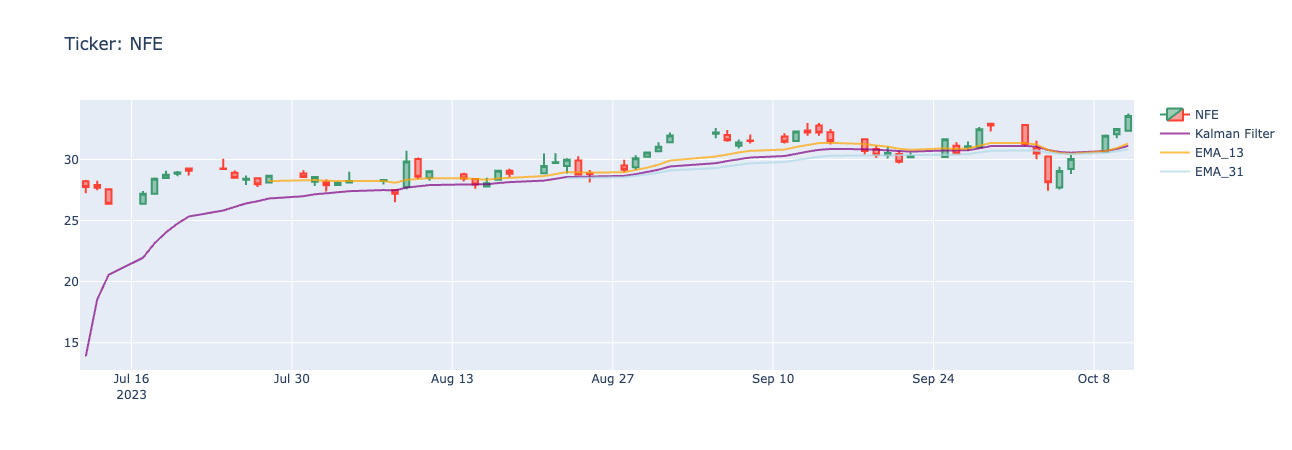

Ticker: ADBE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 549.9099731445312

Ichimoku 9-Day Forecast: 531.2075042724609

Ichimoku 26-Day Forecast: 534.4700012207031

Choppiness (%): 45.75

RSI: 61.438196925478415

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

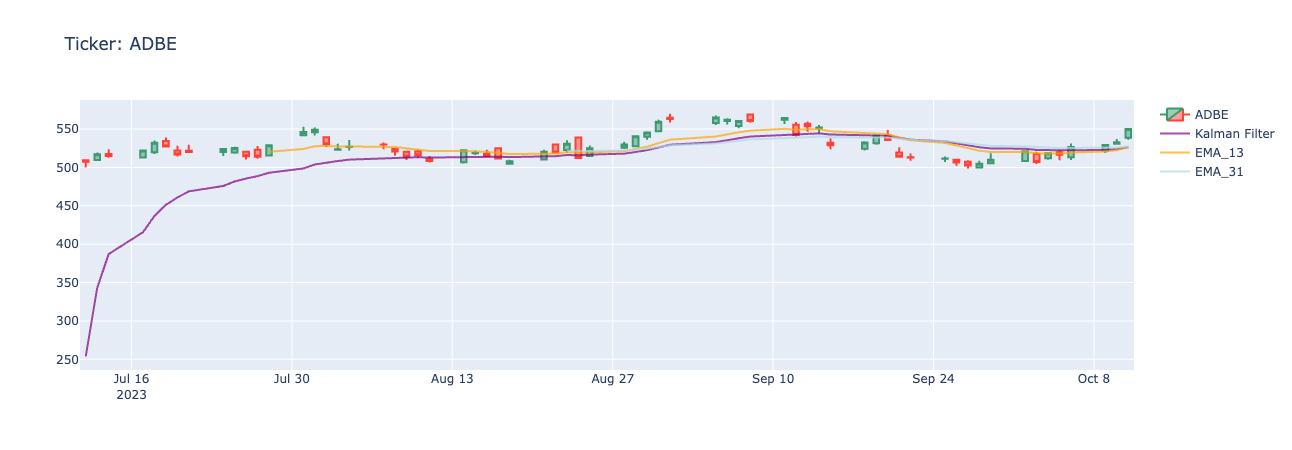

Ticker: WHGLY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 11.199999809265137

Ichimoku 9-Day Forecast: 10.68500018119812

Ichimoku 26-Day Forecast: 10.585000038146973

Choppiness (%): 40.99

RSI: 68.668698125915

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

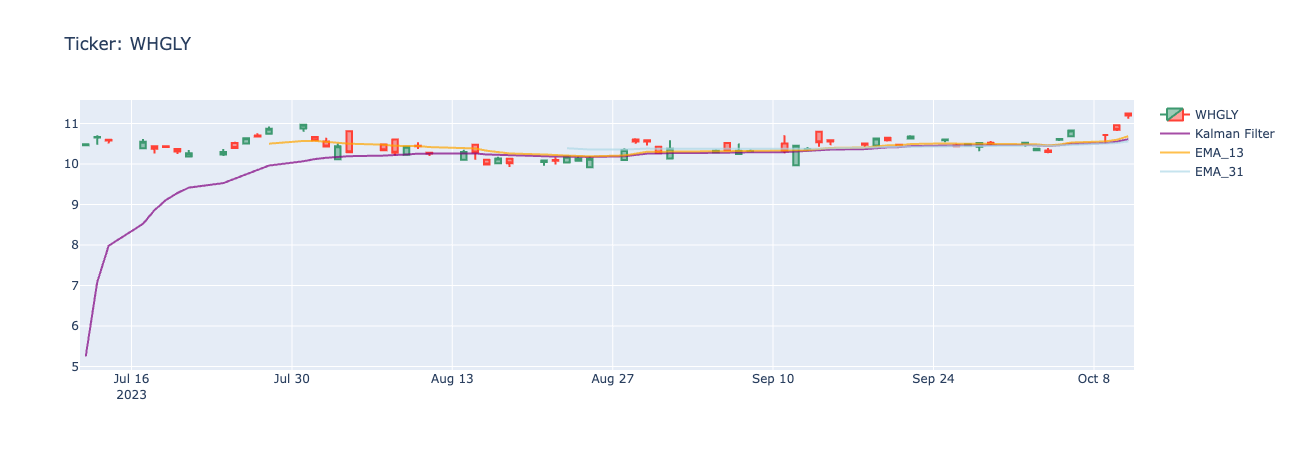

Ticker: LEVI

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 14.460000038146973

Ichimoku 9-Day Forecast: 13.477499961853027

Ichimoku 26-Day Forecast: 13.857500076293945

Choppiness (%): 41.55

RSI: 63.66628994817987

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

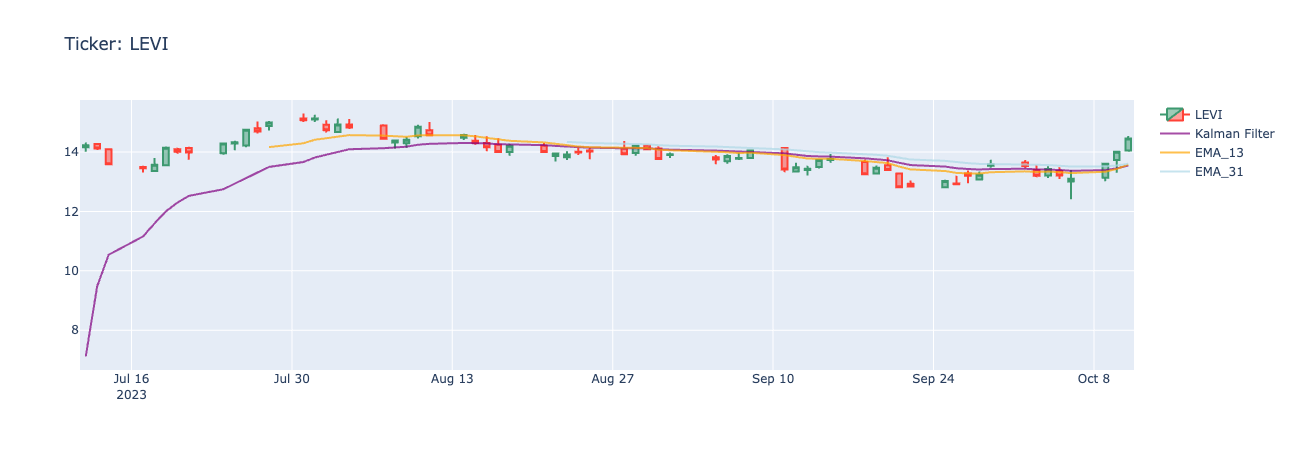

Ticker: BEKE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 16.899999618530273

Ichimoku 9-Day Forecast: 16.430000066757202

Ichimoku 26-Day Forecast: 16.830000400543213

Choppiness (%): 47.59

RSI: 60.064563650074376

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

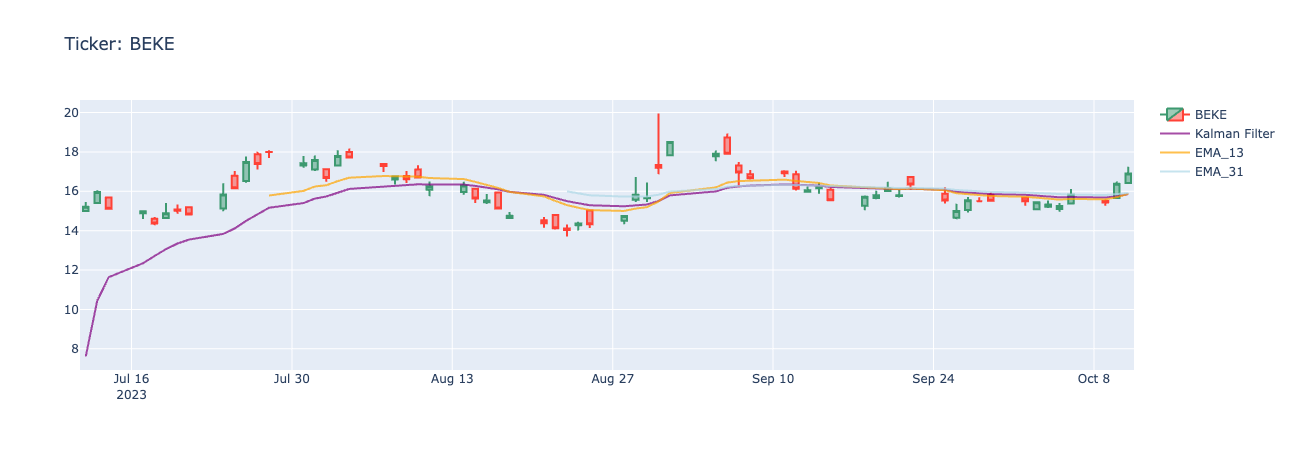

Ticker: NU

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 7.840000152587891

Ichimoku 9-Day Forecast: 7.297500133514404

Ichimoku 26-Day Forecast: 7.4075000286102295

Choppiness (%): 48.30

RSI: 64.17002629095006

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

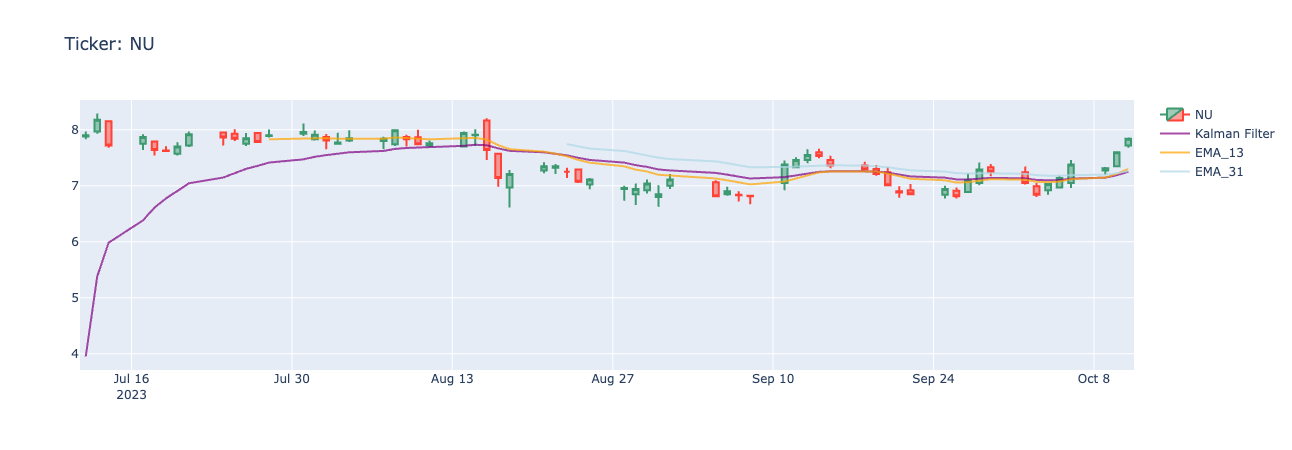

Ticker: JBL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 138.5

Ichimoku 9-Day Forecast: 126.89749908447266

Ichimoku 26-Day Forecast: 119.67499923706055

Choppiness (%): 23.09

RSI: 80.08876945034811

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

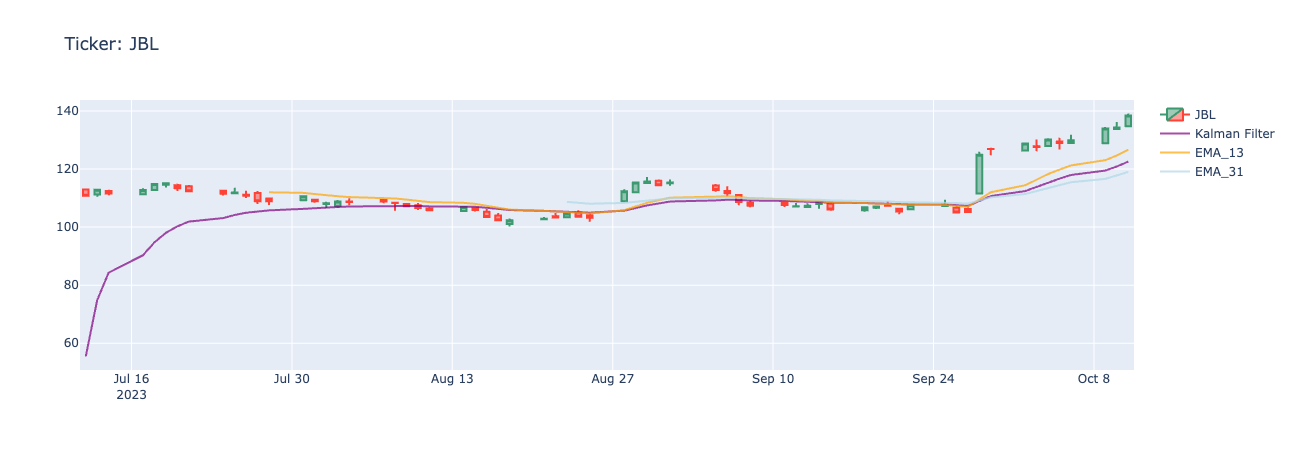

Ticker: HPK

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 16.43000030517578

Ichimoku 9-Day Forecast: 16.005000114440918

Ichimoku 26-Day Forecast: 15.569999694824219

Choppiness (%): 46.43

RSI: 54.94694014138525

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

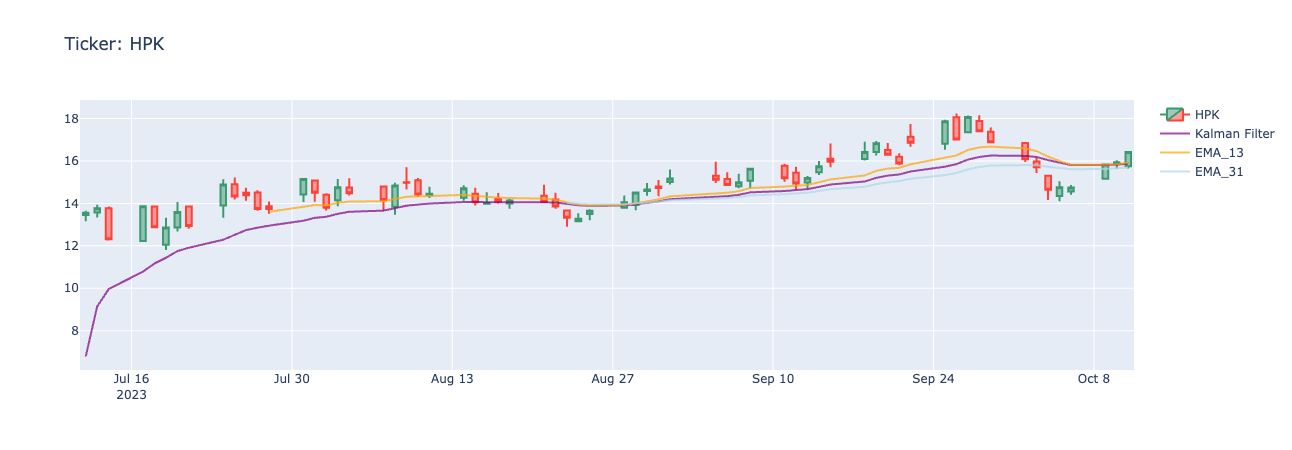

Ticker: STVN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 33.88999938964844

Ichimoku 9-Day Forecast: 30.81999969482422

Ichimoku 26-Day Forecast: 31.359999656677246

Choppiness (%): 39.66

RSI: 68.49316005250702

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

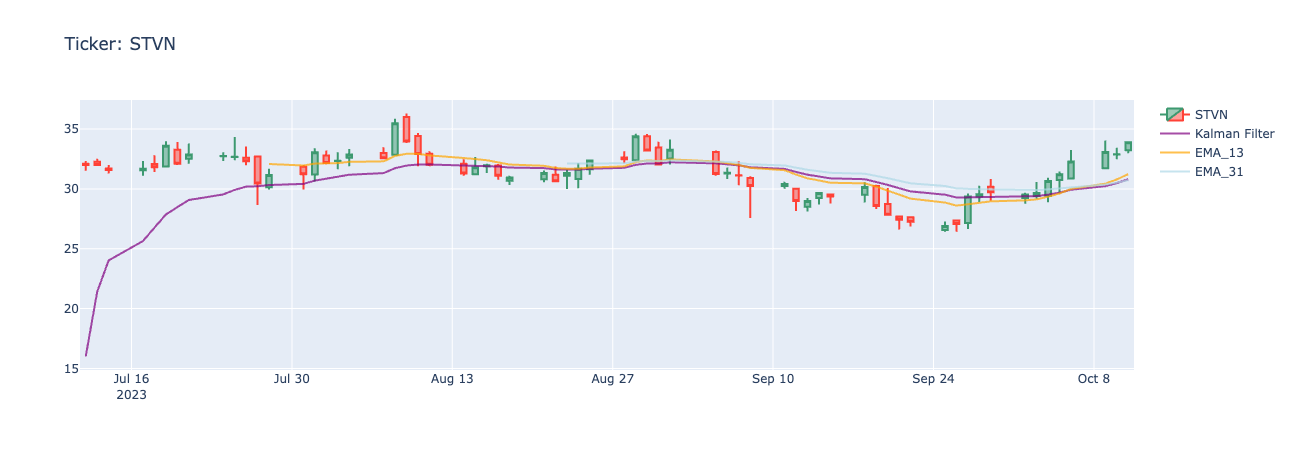

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: GAERF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 10.25

Ichimoku 9-Day Forecast: 8.75

Ichimoku 26-Day Forecast: 8.75

Choppiness (%): 17.70

RSI: 56.689467703344654

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

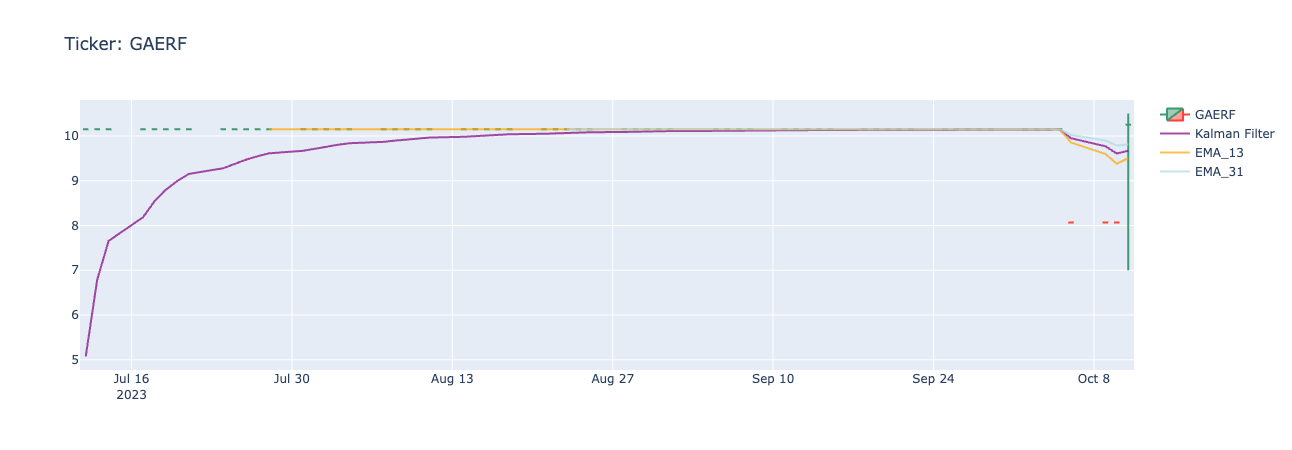

Ticker: ASRMF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 21.0

Ichimoku 9-Day Forecast: 22.28250026702881

Ichimoku 26-Day Forecast: 23.770000457763672

Choppiness (%): 30.81

RSI: 41.219427863359904

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

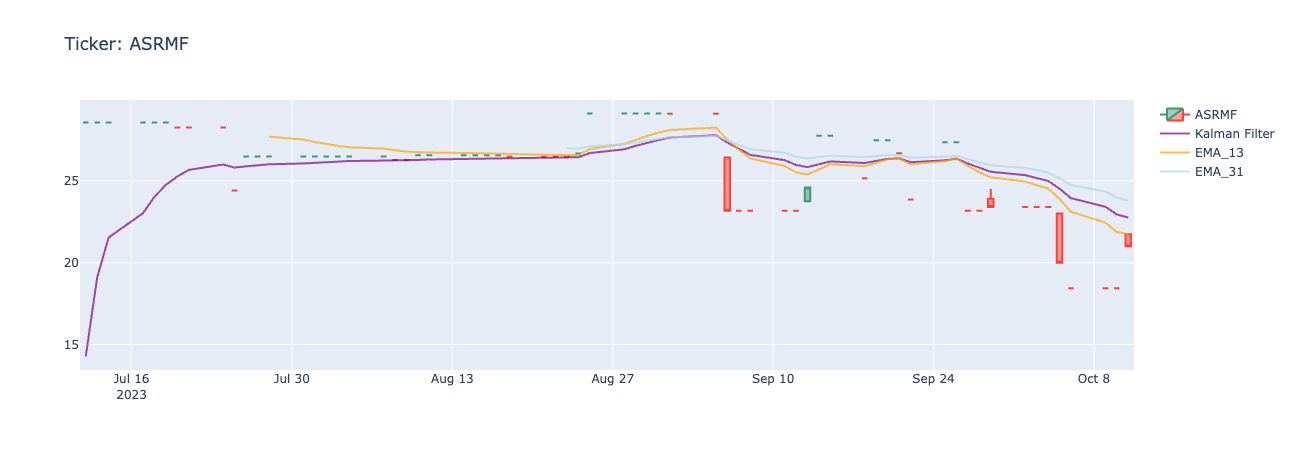

Ticker: TKGBY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 1.9500000476837158

Ichimoku 9-Day Forecast: 1.847499966621399

Ichimoku 26-Day Forecast: 1.875

Choppiness (%): 55.25

RSI: 53.089341694322655

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

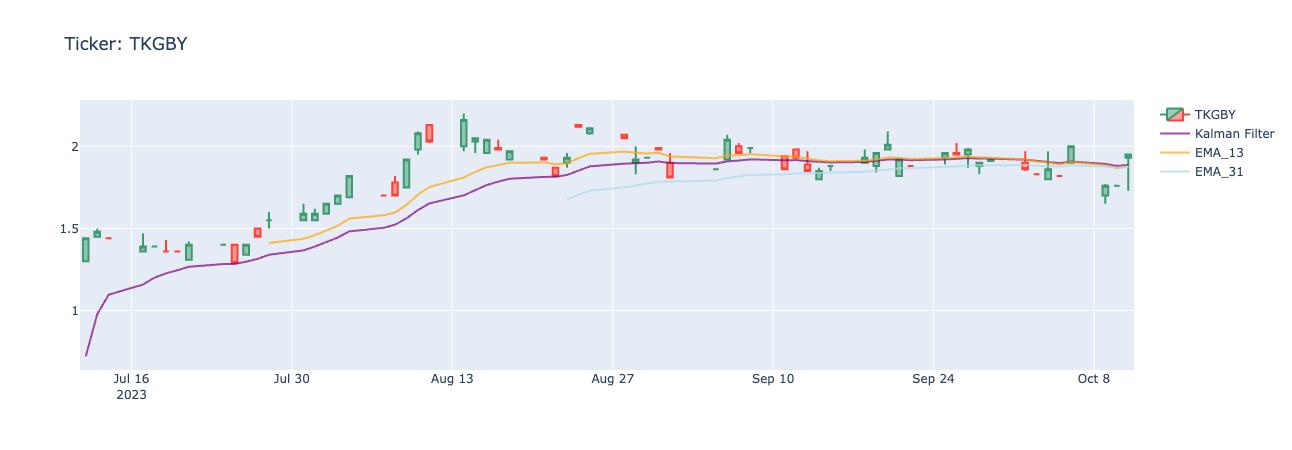

Ticker: TBVPF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 0.4000000059604645

Ichimoku 9-Day Forecast: 0.4089999943971634

Ichimoku 26-Day Forecast: 0.4189999997615814

Choppiness (%): 45.02

RSI: 48.27635769653242

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

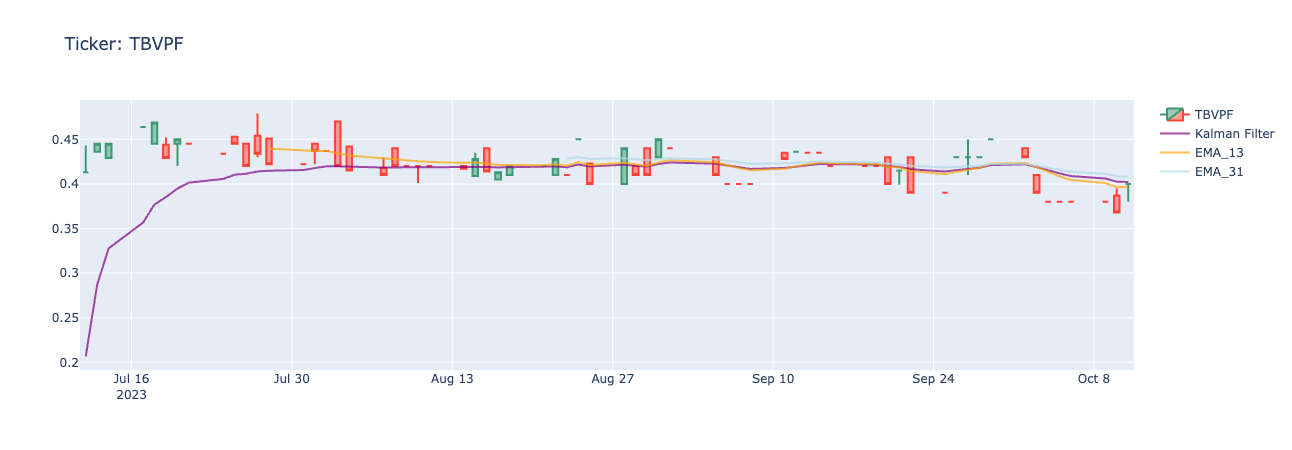

Ticker: NEP

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 23.010000228881836

Ichimoku 9-Day Forecast: 30.973750114440918

Ichimoku 26-Day Forecast: 37.59999942779541

Choppiness (%): 16.62

RSI: 22.54282156418364

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

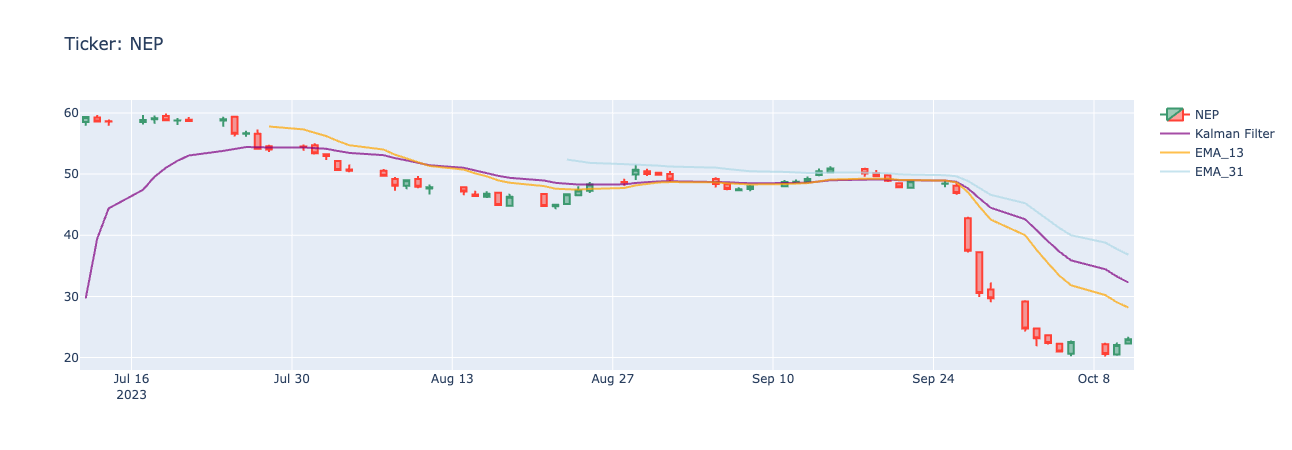

Ticker: STKAF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 2.380000114440918

Ichimoku 9-Day Forecast: 2.455049991607666

Ichimoku 26-Day Forecast: 2.5450499057769775

Choppiness (%): 36.99

RSI: 41.030019006887265

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

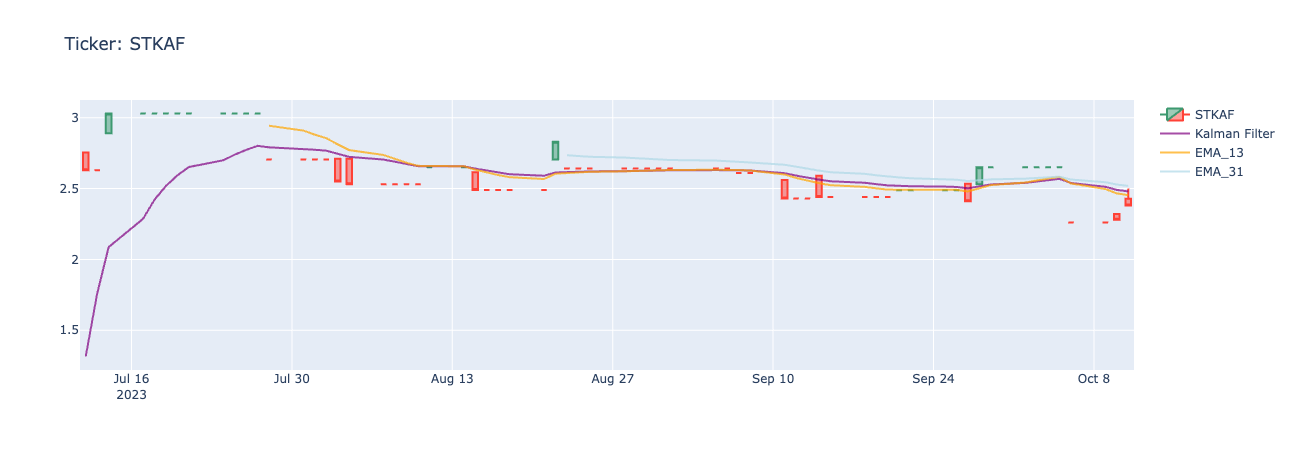

Ticker: PBCRF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 0.5709999799728394

Ichimoku 9-Day Forecast: 0.5847499966621399

Ichimoku 26-Day Forecast: 0.5929999947547913

Choppiness (%): 65.37

RSI: 48.39841386327852

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

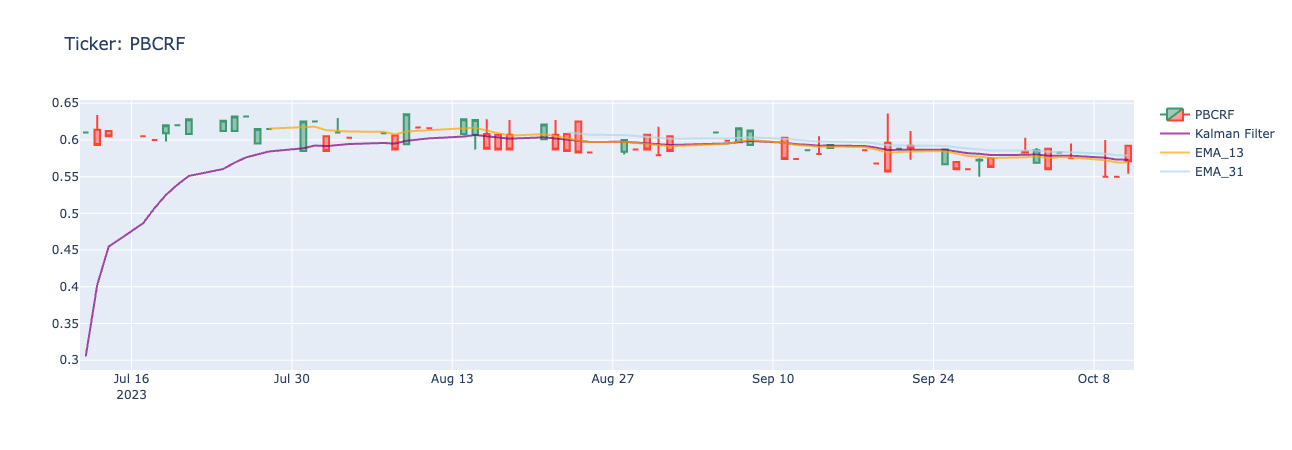

Ticker: NEE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 53.540000915527344

Ichimoku 9-Day Forecast: 55.73750019073486

Ichimoku 26-Day Forecast: 60.810001373291016

Choppiness (%): 25.53

RSI: 33.9088618241407

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

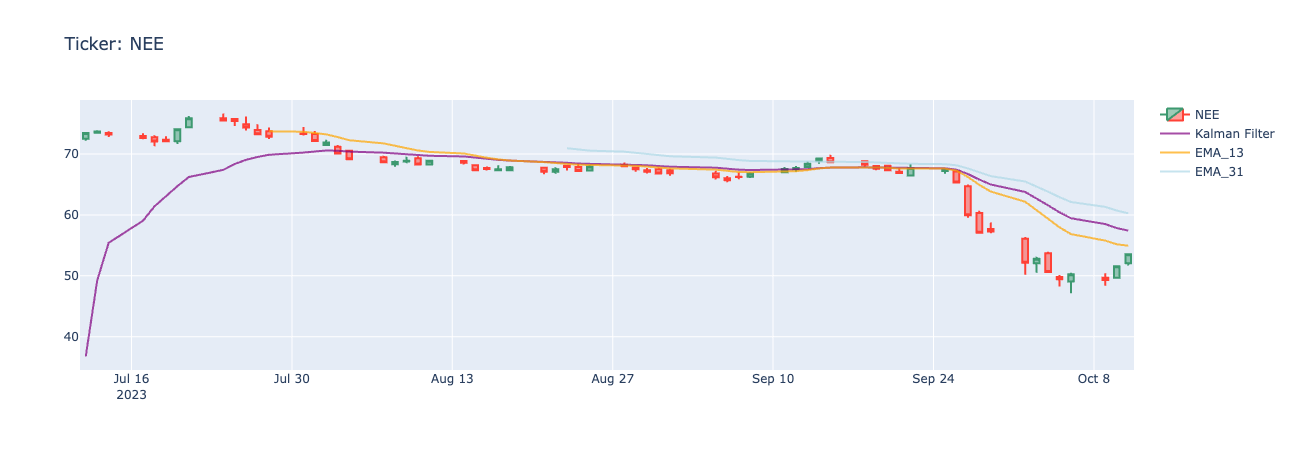

Ticker: OI

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 16.309999465942383

Ichimoku 9-Day Forecast: 16.96999979019165

Ichimoku 26-Day Forecast: 19.359999656677246

Choppiness (%): 38.71

RSI: 36.33728013879377

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

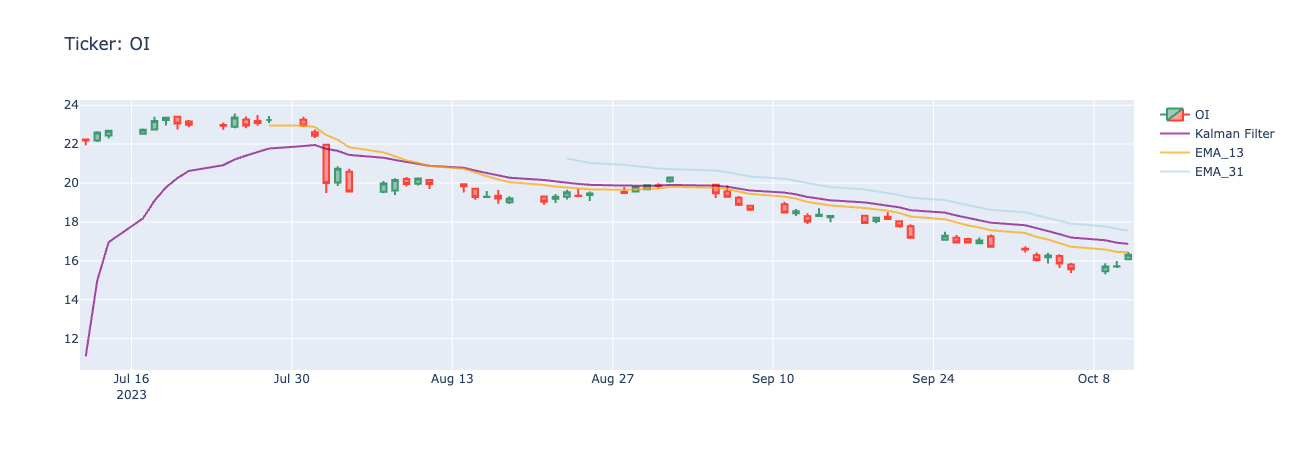

Ticker: TKOMF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 23.040000915527344

Ichimoku 9-Day Forecast: 23.472500324249268

Ichimoku 26-Day Forecast: 22.90499973297119

Choppiness (%): 14.00

RSI: 47.56611353790028

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

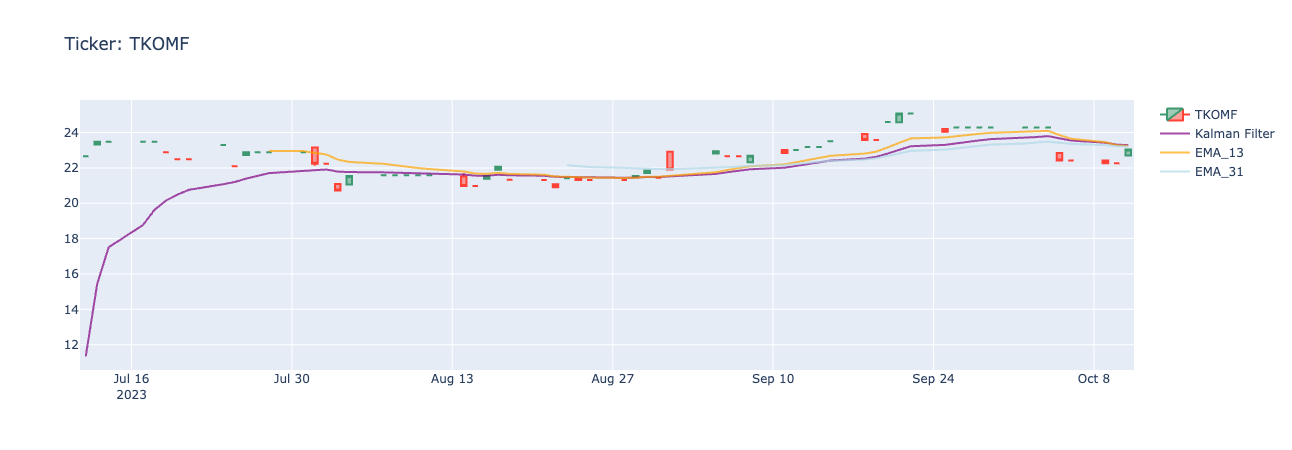

Ticker: GGAL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 12.399999618530273

Ichimoku 9-Day Forecast: 13.764999866485596

Ichimoku 26-Day Forecast: 15.184999465942383

Choppiness (%): 35.14

RSI: 32.39582019152698

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

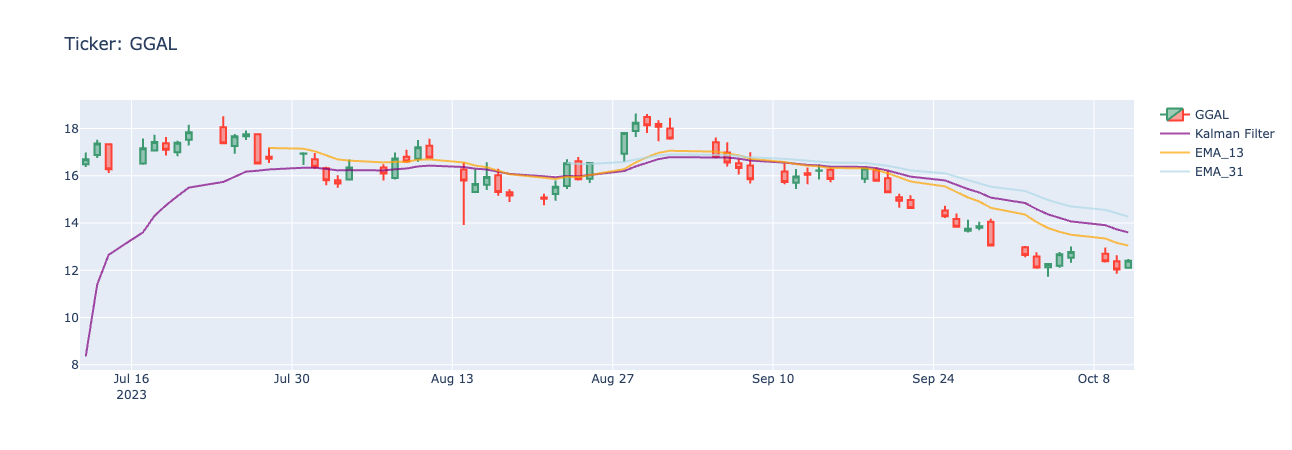

Ticker: NEE-PR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 35.54999923706055

Ichimoku 9-Day Forecast: 36.549574851989746

Ichimoku 26-Day Forecast: 39.18499946594238

Choppiness (%): 27.67

RSI: 35.512210616468266

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

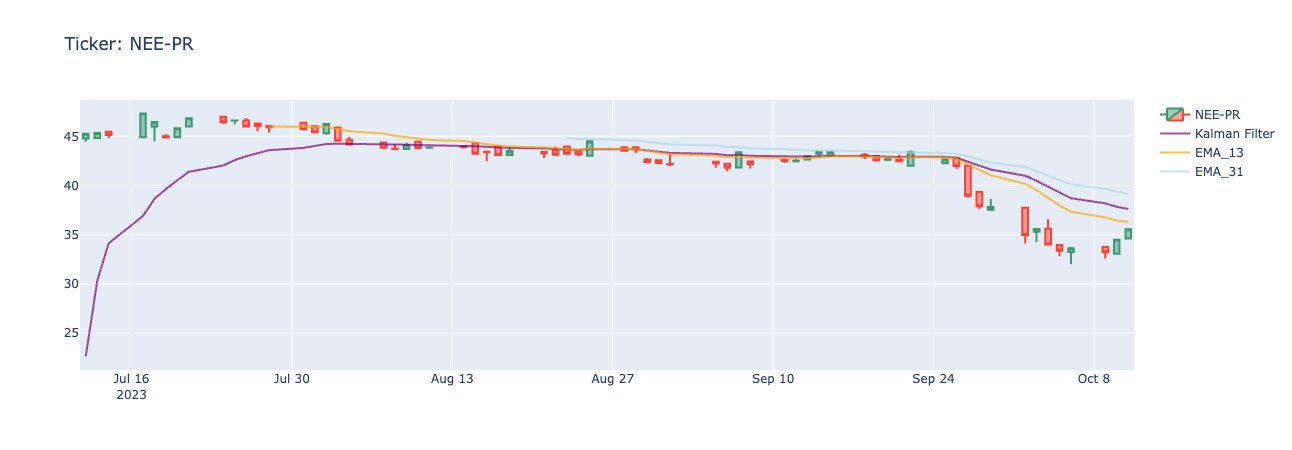

In [16]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if calculate_symbol(v)[8] == True:
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if calculate_symbol(v)[9] == True:
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

In [7]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [ ]:
# Archer Moving Averages Trends
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb
# https://www.tradingview.com/script/Z2mq63fE-Trade-Archer-Moving-Averages-v1-4F/

In [ ]:
# en fin